In [2]:
import pandas as pd

# Load the data
firearm_provisions = pd.read_csv('Firearm_Provisions.csv')
gun_violence_data = pd.read_csv('Gun_Violence_Data.csv')
mass_shooters = pd.read_csv('Mass_Shooters.csv')
mass_shootings = pd.read_csv('Mass_Shootings.csv')
mortality_by_state = pd.read_csv('Mortality_By_State.csv')

mortality_by_state.head()


,mortality_id,YEAR,STATE,RATE,DEATHS
0,1,2022,AL,25.5,1278
1,2,2022,AK,22.4,164
2,3,2022,AZ,20.1,1535
3,4,2022,AR,21.9,666
4,5,2022,CA,8.6,3484


In [3]:
# Merge Firearm Provisions with Mortality by State using state and year as keys
firearm_mortality_merged = pd.merge(
    firearm_provisions, 
    mortality_by_state, 
    left_on=["state", "year"], 
    right_on=["STATE", "YEAR"], 
    how="inner"
)

# Merge the resulting data with Gun Violence Data by state and year
full_data_merged = pd.merge(
    firearm_mortality_merged,
    gun_violence_data,
    left_on=["state", "year"],
    right_on=["state", "year"],
    how="inner"
)

# Drop unnecessary duplicate columns from merging
full_data_merged.drop(columns=["STATE", "YEAR"], inplace=True)

# Display a preview of the combined dataset
full_data_merged.head()


,provision_id,state,year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,...,violentpartial,waiting,waitingh,lawtotal,mortality_id,RATE,DEATHS,incident_id,n_killed,n_injured
0,1151,AL,2014,0,0,0,0,0,0,0,...,0,0,0,10,402,16.9,815,92342,1,0
1,1151,AL,2014,0,0,0,0,0,0,0,...,0,0,0,10,402,16.9,815,94194,0,3
2,1151,AL,2014,0,0,0,0,0,0,0,...,0,0,0,10,402,16.9,815,92337,1,0
3,1151,AL,2014,0,0,0,0,0,0,0,...,0,0,0,10,402,16.9,815,95279,0,1
4,1151,AL,2014,0,0,0,0,0,0,0,...,0,0,0,10,402,16.9,815,92456,0,0


In [4]:
# Predicting High-Risk Locations

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Feature selection for predicting high-risk locations
# Ensure 'full_data_merged' is loaded before executing this block
features = full_data_merged[['lawtotal', 'RATE', 'n_killed', 'n_injured']]
target = (full_data_merged['n_killed'] > 0).astype(int)  # Binary target: 1 if incident occurred, 0 otherwise

# Check for NaN values and handle them if necessary
features = features.fillna(0)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Training a random forest classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Display the evaluation results
print("Classification Report:\n", report)
print("ROC-AUC Score:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34551
           1       1.00      1.00      1.00      9966

    accuracy                           1.00     44517
   macro avg       1.00      1.00      1.00     44517
weighted avg       1.00      1.00      1.00     44517

ROC-AUC Score: 1.0


In [13]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Update train-test split with normalized features
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [14]:
# Modify random forest with regularization
model_regularized = RandomForestClassifier(
    random_state=42, 
    n_estimators=100, 
    max_depth=20,       # Limit depth of trees
    min_samples_split=10,  # Require more samples to split nodes
    min_samples_leaf=5    # Require more samples in leaf nodes
)
model_regularized.fit(X_train, y_train)

# Evaluate the regularized model
y_pred_reg = model_regularized.predict(X_test)
y_prob_reg = model_regularized.predict_proba(X_test)[:, 1]

print("Classification Report (Regularized):\n", classification_report(y_test, y_pred_reg))
print("ROC-AUC Score (Regularized):", roc_auc_score(y_test, y_prob_reg))


Classification Report (Regularized):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34551
           1       1.00      1.00      1.00      9966

    accuracy                           1.00     44517
   macro avg       1.00      1.00      1.00     44517
weighted avg       1.00      1.00      1.00     44517

ROC-AUC Score (Regularized): 1.0


In [7]:
# Predict probabilities for all data
full_data_merged['high_risk_prob_refined'] = model_regularized.predict_proba(features_scaled)[:, 1]

# Save high-risk locations
high_risk_locations_refined = full_data_merged[['state', 'year', 'high_risk_prob_refined']].sort_values(
    by='high_risk_prob_refined', ascending=False
)
high_risk_locations_refined.to_csv('high_risk_locations_refined.csv', index=False)
print("Refined high-risk locations saved to 'high_risk_locations_refined.csv'")


Refined high-risk locations saved to 'high_risk_locations_refined.csv'


In [8]:
# Add predictions from the original model
full_data_merged['high_risk_prob'] = model.predict_proba(features_scaled)[:, 1]

print(full_data_merged.columns)

/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Index(['provision_id', 'state', 'year', 'age18longgunpossess',
       'age18longgunsale', 'age21handgunpossess', 'age21handgunsale',
       'age21longgunpossess', 'age21longgunsale', 'age21longgunsaled',
       ...
       'waitingh', 'lawtotal', 'mortality_id', 'RATE', 'DEATHS', 'incident_id',
       'n_killed', 'n_injured', 'high_risk_prob_refined', 'high_risk_prob'],
      dtype='object', length=145)


In [9]:
print(full_data_merged[['high_risk_prob', 'high_risk_prob_refined']].head())

   high_risk_prob  high_risk_prob_refined
0             1.0                     1.0
1             0.0                     0.0
2             1.0                     1.0
3             0.0                     0.0
4             0.0                     0.0


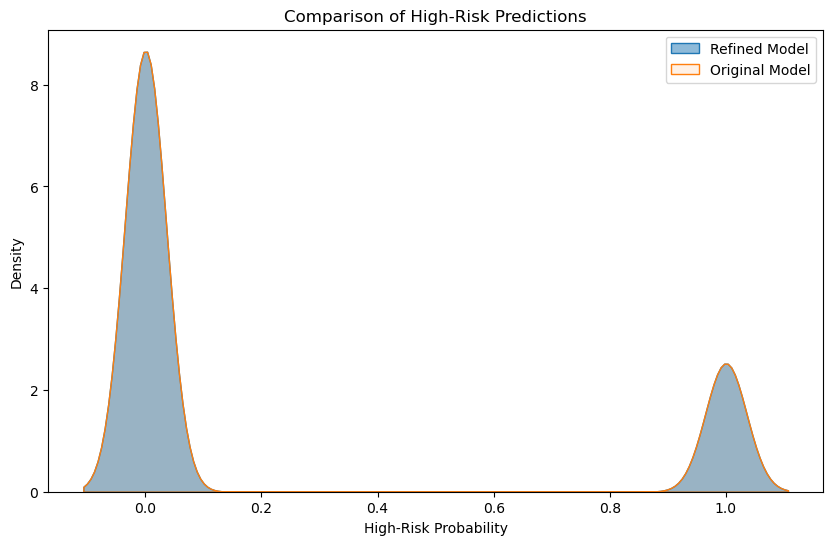

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine predictions into a DataFrame
comparison_df = pd.DataFrame({
    'Original': full_data_merged['high_risk_prob'],
    'Refined': full_data_merged['high_risk_prob_refined']
})

# Plot density plots for comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(comparison_df['Refined'], label='Refined Model', fill=True, alpha=0.5)
sns.kdeplot(comparison_df['Original'], label='Original Model', fill=True, alpha=0.1)
plt.title('Comparison of High-Risk Predictions')
plt.xlabel('High-Risk Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


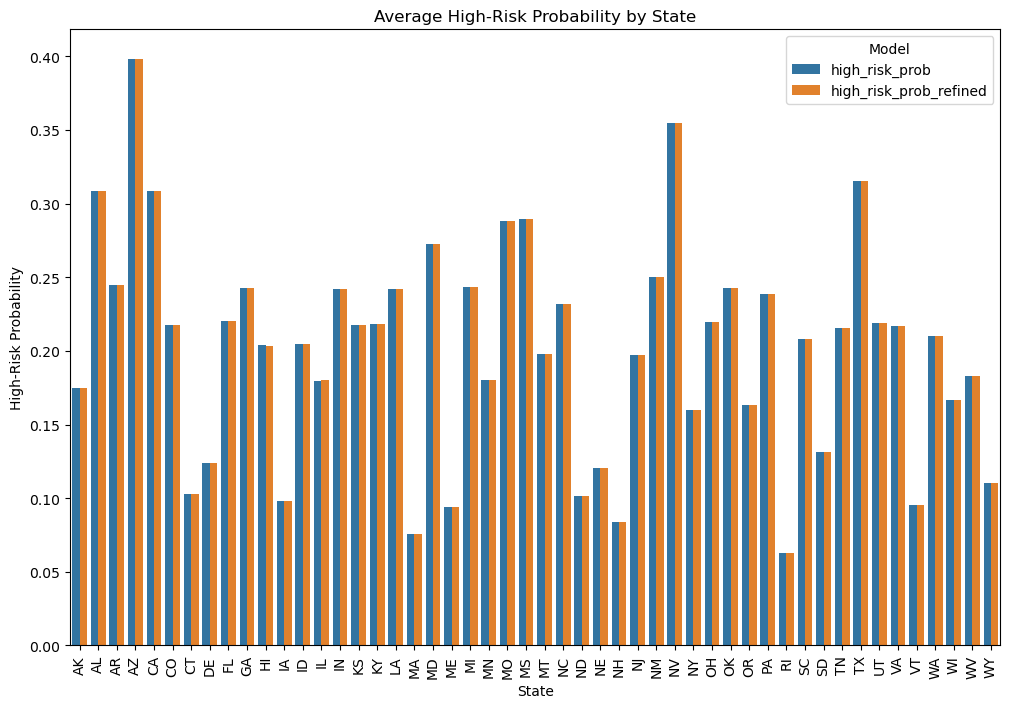

In [11]:
# Group by state and calculate averages
state_comparison = full_data_merged.groupby('state').agg({
    'high_risk_prob': 'mean',
    'high_risk_prob_refined': 'mean'
}).reset_index()

# Melt data for easier plotting
state_comparison_melted = state_comparison.melt(
    id_vars='state', var_name='Model', value_name='Average High-Risk Probability'
)

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=state_comparison_melted, x='state', y='Average High-Risk Probability', hue='Model')
plt.xticks(rotation=90)
plt.title('Average High-Risk Probability by State')
plt.ylabel('High-Risk Probability')
plt.xlabel('State')
plt.legend(title='Model')
plt.show()

In [ ]:
# Pivot data for heatmap
heatmap_original = full_data_merged.pivot_table(index='state', columns='year', values='high_risk_prob')
heatmap_refined = full_data_merged.pivot_table(index='state', columns='year', values='high_risk_prob_refined')

# Plot heatmap for the original model
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_original, cmap='Reds', cbar_kws={'label': 'High-Risk Probability'})
plt.title('High-Risk Probability (Original Model)')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

# Plot heatmap for the refined model
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_refined, cmap='Blues', cbar_kws={'label': 'High-Risk Probability'})
plt.title('High-Risk Probability (Refined Model)')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

In [ ]:
feature_importances = model.feature_importances_
plt.barh(features.columns, feature_importances)
plt.title("Feature Importance")
plt.show()

In [ ]:
correlations = full_data_merged[['high_risk_prob', 'RATE', 'lawtotal']].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Subset analysis: States with high vs. low law totals
high_law_states = full_data_merged[full_data_merged['lawtotal'] > full_data_merged['lawtotal'].median()]
low_law_states = full_data_merged[full_data_merged['lawtotal'] <= full_data_merged['lawtotal'].median()]

# Compare average high-risk probabilities
print("High-Law States Avg Risk:", high_law_states['high_risk_prob'].mean())
print("Low-Law States Avg Risk:", low_law_states['high_risk_prob'].mean())


In [ ]:
# Rank states by average high-risk probability
top_locations = full_data_merged.groupby('state')['high_risk_prob'].mean().sort_values(ascending=False)
print("Top High-Risk States:\n", top_locations.head(10))

In [ ]:
# Rank high-risk states for a specific year
year_specific = full_data_merged[full_data_merged['year'] == 2014]  # Adjust year
top_locations_year = year_specific.groupby('state')['high_risk_prob'].mean().sort_values(ascending=False)
print("Top High-Risk States for 2014:\n", top_locations_year.head(10))

In [ ]:
# Identifying the Most Effective Laws

# Feature importance from the model
feature_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances)

In [ ]:
# Correlation analysis
laws = ['age18longgunpossess', 'age21handgunpossess', 'waiting', 'lawtotal']  # Add relevant laws
correlation_matrix = full_data_merged[['high_risk_prob'] + laws].corr()
print("Correlation Matrix:\n", correlation_matrix)

In [ ]:
from scipy.stats import ttest_ind

# Example: Compare states with and without 'waiting' laws
with_law = full_data_merged[full_data_merged['waiting'] > 0]
without_law = full_data_merged[full_data_merged['waiting'] == 0]

t_stat, p_value = ttest_ind(with_law['high_risk_prob'], without_law['high_risk_prob'])
print("T-Statistic:", t_stat)
print("P-Value:", p_value)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add a column to distinguish groups
full_data_merged['waiting_period'] = full_data_merged['waiting'] > 0

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='waiting_period', y='high_risk_prob', data=full_data_merged)
plt.title('High-Risk Probabilities by Waiting Periods')
plt.xlabel('Waiting Period (True = Yes)')
plt.ylabel('High-Risk Probability')
plt.show()

In [ ]:
with_law_mean = with_law['high_risk_prob'].mean()
without_law_mean = without_law['high_risk_prob'].mean()
with_law_std = with_law['high_risk_prob'].std()
without_law_std = without_law['high_risk_prob'].std()

print(f"With Waiting Period - Mean: {with_law_mean}, Std: {with_law_std}")
print(f"Without Waiting Period - Mean: {without_law_mean}, Std: {without_law_std}")